In [1]:
from util import get_tickers
from pandas_datareader import data as pdr

In [2]:
# how many days to predict
PREDICT_PERIOD=128

# the minimal number of data entries for a stock
MIN_TOTAL_DATA_PER_STOCK = 1000
MIN_TRAINING_DATA_PER_STOCK = 500
MIN_TEST_DATA_PER_STOCK = 300

In [3]:
tickers = get_tickers('dax_40.txt') + get_tickers('ftse_100.txt') + get_tickers('sp_500.txt') + get_tickers('omx_30.txt')

In [4]:
import random
import pandas as pd
random.seed(42)
# Assuming 'tickers' is your list of strings
selected_tickers = random.sample(tickers, 10)

#selected_tickers = tickers

In [5]:
# import re  # Regular expressions module

# # Define the path to your file
# file_path = 'data/recommended_gpt4.txt'

# # Initialize an empty list to store ticker names
# ticker_names = []

# # Open and read the file
# try:
#     with open(file_path, 'r') as file:
#         for line in file:
#             # Use regular expression to find the ticker name in parentheses
#             match = re.search(r'\((.*?)\)', line)
#             if match:
#                 # If a match is found, extract the ticker name and add it to the list
#                 ticker_names.append(match.group(1))
# except FileNotFoundError:
#     print(f"The file at {file_path} was not found.")

# # Print the list of ticker names
# print(ticker_names)
# selected_tickers = ticker_names

In [6]:
import random
import pandas as pd
random.seed(42)

#selected_tickers = random.sample(selected_tickers, 10)
len(selected_tickers)

10

In [7]:
period = 128  # trading days in half year


In [8]:
import os
import numpy as np
from datetime import timedelta
import time

def nth_weekday_of_month(year, month, index, weekday):
  """
  Find the nth occurrence of a specific weekday in a given month.

  :param year: The year as an integer.
  :param month: The month as an integer (1-12).
  :param index: The index of the occurrence (1st, 2nd, 3rd, etc.)
  :param weekday: The day of the week as an integer where Monday is 1 and Sunday is 7.
  :return: The date of the nth weekday.
  """

  weekday = weekday - 1
  # Start at the beginning of the month
  first_day_of_month = pd.Timestamp(year=year, month=month, day=1)
  # Find the first occurrence of the specific weekday
  first_weekday = first_day_of_month + timedelta(days=((weekday - first_day_of_month.weekday()) + 7) % 7)
  
  # Add (index - 1) weeks to the first occurrence of the weekday
  nth_weekday = first_weekday + timedelta(weeks=index-1)
  return nth_weekday.day

def is_file_downloaded_recently(file_path, seconds=36000):
  if not os.path.exists(file_path):
    return False
  file_age = time.time() - os.path.getmtime(file_path)
  return file_age <= seconds

def get_table_by_id_fred(id, path, n_features, 
                         start='1950-01-01', end="2024-01-01", if_log=True):
  print('start:', start, 'end:', end)
  feature_columns = []
  if path is None:
    path = 'data/fred'

  file_path = os.path.join(path, f'{id}.csv')
  if not is_file_downloaded_recently(file_path):
    print(f'Metric: {id} need to be refreshed...')
    df = pdr.get_data_fred(id, start='1950-01-01', end=None)
    df.to_csv(f'data/fred/{id}.csv')

  df = pd.read_csv(os.path.join(path, f'{id}.csv'), index_col='DATE', parse_dates=True)
  df = df[start:end]

  if if_log:
    df[f'log_{id}'] = np.log(df[id])

  n_days = [int(2**n) for n in range(n_features)]
  for n in n_days:
    if if_log:
      name = f'log_{id}_diff_{n}'
      df[name] = df[f'log_{id}'] - df[f'log_{id}'].shift(n)
    else:
      name = f'{id}_diff_{n}'
      df[name] = df[id] - df[id].shift(n)
    feature_columns.append(name)
  return df, feature_columns

def merge_fred(df, id, n_features, start, end, release_week_index, release_week_day, if_log=True):
  path = 'data/fred'
  df_new, columns = get_table_by_id_fred(id, path, n_features, start=start, end=end, if_log=if_log)
  print(f"last update for {id}", df_new.iloc[-1].name, df_new.iloc[-1][id])

  def get_last_metric_date(row, release_week_index, release_week_day):
    year = row.name.year
    month = row.name.month
    day = row.name.day

    release_date = nth_weekday_of_month(year, month, release_week_index, release_week_day)
    if day <= release_date:
      if month == 1:
        year -= 1
        month = 11
      elif month == 2:
        year -= 1
        month = 12
      else:
        month -= 2
    else:
      if month == 1:
        year -= 1
        month = 12
      else:
        month -= 1
    
    return pd.to_datetime(f"{year}-{month}-01")
  
  df['LAST_METRIC_DATE'] = df.apply(get_last_metric_date, axis=1, 
                                    args=(release_week_index, release_week_day))
  
  df = pd.merge_asof(df, df_new[columns], left_on='LAST_METRIC_DATE', right_index=True)
  # delete the column 'LAST_METRIC_DATE'
  df = df.drop(columns=['LAST_METRIC_DATE'])
  return df, columns

In [9]:
def remove_nan(df, type='top'):
  if type == 'top':
    for i in range(len(df)):
      if df.iloc[i].isnull().any() == False:
        break
    df_top = df[:i]
    df = df[i:]

    return df, df_top
  
  elif type == 'bottom':
    for i in range(1, len(df)):
      if df.iloc[-i].isnull().any() == False:
        break
    df_tail = df[-i:]
    df = df[:-i]
    return df, df_tail

In [10]:
def add_features(df, n_features):
  feature_columns = []
  for i in range(n_features):
    n_days = 2**i

    df[f'log_price_diff_{n_days}'] = np.log(df['Adj Close'].shift(n_days))/df['Adj Close']
    #df[f'price_diff_{n_days}'] = pd.to_numeric(df[f'price_diff_{n_days}'], errors='coerce')
    log_volume = np.log(df['Volume']+1e-8)
    df[f'log_volume_diff_{n_days}'] = log_volume - log_volume.shift(n_days)
    feature_columns.append(f'log_price_diff_{n_days}')
    feature_columns.append(f'log_volume_diff_{n_days}')
    #feature_columns.append(f'volume_diff_{n_days}')
  return df, feature_columns

In [11]:
# Map the stock suffixes to their base currencies
currency_mapping = {
  '.ST': 'SEK',
  '.DE': 'EUR',
  '.L': 'GBP'
}

# Map currency pairs to directions
conversion_mapping = {
  ('SEK', 'USD'): ('DEXSDUS', True),
  ('EUR', 'USD'): ('DEXUSEU', False),
  ('GBP', 'USD'): ('DEXUSUK', False),
}


def get_currency_pair(stock_suffix, base_currency):
    stock_base_currency = currency_mapping.get(stock_suffix, 'USD')
    if base_currency == stock_base_currency:
        return None, None  # No conversion needed
    else:
        return conversion_mapping.get((stock_base_currency, base_currency))


def read_and_filter_exchange_rates(exchange_name):
  return read_and_filter(exchange_name, 'data/fred')

def read_and_filter(name, path):
  filepath = f'{path}/{name}.csv'
  df = pd.read_csv(filepath, index_col='DATE', parse_dates=True)
  return df

def convert(df, exchange_name, inversion):
  df_rate = read_and_filter_exchange_rates(exchange_name)
  start = max(df.index[0], df_rate.index[0])
  df = df[df.index >= start]
  df_rate = df_rate[df_rate.index >= start]

  df_rate = df_rate[[exchange_name]]
  if inversion:
    df_rate[exchange_name] = 1/df_rate[exchange_name]
  df_merged = pd.merge_asof(df, df_rate, left_index=True, right_index=True, direction='nearest')
  df_merged['Adj Close'] = df_merged['Adj Close'] * df_merged[exchange_name]
  return df_merged[['Adj Close', 'Volume']]

In [12]:
def load_latest_price_data(stock_name, start='1950-01-01'):
  file_path = f'data/prices/{stock_name}.csv'
  if not is_file_downloaded_recently(file_path):
    data = pdr.get_data_yahoo(stock_name, start=start, end=None)
    print('data downloaded:', data.head())
    if len(data) > 100:
      data.to_csv(file_path)
    else:
      print(f'Cannot download {stock_name}, using old data...')

  df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
  return df

In [13]:

def get_X_y_by_stock(stock_name, period, split_date='2018-01-01'):
  print(f'processing {stock_name}...')
  try:
    df = load_latest_price_data(stock_name)
  except FileNotFoundError:
    print(f'Cannot find data for: {stock_name}')
    return None, None, None, None
  


  print('initial size:', len(df))
  if len(df) < MIN_TOTAL_DATA_PER_STOCK:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None

  stock_suffix = '.' + stock_name.split('.')[-1]
  exchange_name, needs_inversion = get_currency_pair(stock_suffix, 'USD')
  if exchange_name is not None:
    df = convert(df, exchange_name, needs_inversion)
    
  if len(df) == 0:
    print(f'empty table...')
    return None, None, None, None

  df, feature_columns = add_features(df, 10)
  
  # the predict is the log return of period days.
  df['log_predict'] = np.log(df['Adj Close'].shift(-period) / df['Adj Close'])
  print('log predict: ',  len(df['log_predict'].dropna()))

  timestamp = df.index[0]
  earliest_date = timestamp.strftime('%Y-%m-%d')
  start = earliest_date
  end = None



  df, columns = merge_fred(df, 'M2SL', 6, start, end, 4, 2, if_log=True)
  feature_columns += columns

  
  df, columns = merge_fred(df, 'UNRATE', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns

  df, columns = merge_fred(df, 'FEDFUNDS', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns

  print('before removing: ', len(df))
  df, _ = remove_nan(df, type='top')
  if len(df) < MIN_TOTAL_DATA_PER_STOCK:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None
  print('top removed, length: ', len(df))
  df, _ = remove_nan(df, type='bottom')
  if len(df) < MIN_TOTAL_DATA_PER_STOCK:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None
  
  print('bottom removed, length: ', len(df))
  df = df[feature_columns + ['log_predict']]
  df.dropna(inplace=True)
  print('dropna removed, final length:', len(df))
  
  if len(df) < MIN_TOTAL_DATA_PER_STOCK:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None
  
  df_test = df[df.index >= split_date]
  df_train = df[df.index < split_date]
  if len(df_train) < MIN_TRAINING_DATA_PER_STOCK:
    print(f'Cannot find enough training data for: {stock_name}')
    return None, None, None, None
  if len(df_test) < MIN_TEST_DATA_PER_STOCK:
    print(f'Cannot find enough test data for: {stock_name}')
    return None, None, None, None
  df_train_X = df_train[feature_columns]
  df_train_y = df_train[['log_predict']]
  df_test_X = df_test[feature_columns]
  df_test_y = df_test[['log_predict']]

  return df_train_X, df_train_y, df_test_X, df_test_y

In [14]:
def get_mse_from_hist_average(df_X, df_y, window_size):
  return ((df_X['log_price_diff_128'].rolling(window=window_size).mean()[window_size:] - df_y['log_predict'][window_size:])**2).mean()

In [15]:
df_train_X, df_train_y, df_test_X, df_test_y = get_X_y_by_stock('AAPL', 128)

processing AAPL...


[*********************100%%**********************]  1 of 1 completed


data downloaded:                 Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086999  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600
initial size: 10944
log predict:  10816
start: 1980-12-12 end: None
Metric: M2SL need to be refreshed...
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1980-12-12 end: None
Metric: UNRATE need to be refreshed...
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1980-12-12 end: None
Metric: FEDFUNDS need to be refreshed...
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  10944
top removed, length:  10218
bottom removed, length:  10089
dr

In [16]:
def get_X_y(selected_tickers, period):
  df_train_X_all = []
  df_train_y_all = []
  df_test_X_all = []
  df_test_y_all = []
  mean_square_errors_1 = []
  mean_square_errors_3 = []
  mean_square_errors_5 = []
  valid_tickers = []
  for stock_name in selected_tickers:
    df_train_X, df_train_y, df_test_X, df_test_y = get_X_y_by_stock(stock_name, period)
    if df_train_X is None:
      continue 
    

    valid_tickers.append(stock_name)
    df_train_X_all.append(df_train_X)
    df_train_y_all.append(df_train_y)
    df_test_X_all.append(df_test_X)
    df_test_y_all.append(df_test_y)
    
    mse_1 = get_mse_from_hist_average(df_test_X, df_test_y, 1)
    mse_3 = get_mse_from_hist_average(df_test_X, df_test_y, 3)
    mse_5 = get_mse_from_hist_average(df_test_X, df_test_y, 5)

    mean_square_errors_1.append(mse_1)
    mean_square_errors_3.append(mse_3)
    mean_square_errors_5.append(mse_5)

  return valid_tickers, df_train_X_all, df_train_y_all, df_test_X_all, df_test_y_all, {'mse_1': mean_square_errors_1, 'mse_3': mean_square_errors_3, 'mse_5': mean_square_errors_5}


In [17]:
valid_tickers, df_train_X_all, df_train_y_all, df_test_X_all, df_test_y_all, mses = get_X_y(selected_tickers, PREDICT_PERIOD)    

processing EVO.ST...


[*********************100%%**********************]  1 of 1 completed

data downloaded:                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-03-20  18.450001  19.049999  17.799999  17.950001  17.568878  19791765
2015-03-23  18.100000  18.100000  17.450001  17.549999  17.177370   3763595
2015-03-24  17.650000  18.400000  17.549999  18.200001  17.813568   4625530
2015-03-25  18.350000  18.400000  18.049999  18.049999  17.666754   1037285
2015-03-26  17.950001  18.400000  17.850000  18.400000  18.009319   1342585


initial size: 2302
log predict:  2019
start: 2015-03-20 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 2015-03-20 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 2015-03-20 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  2302
top removed, length:  1581
bottom removed, length:  1452
dropna removed, final length: 925
Cannot find enough data for: EVO.ST
processing RR.L...


[*********************100%%**********************]  1 of 1 completed


data downloaded:                   Open        High         Low       Close  Adj Close  Volume
Date                                                                         
1988-07-01  125.477501  125.477501  125.477501  125.477501  58.676826       0
1988-07-04  126.442703  126.442703  126.442703  126.442703  59.128185       0
1988-07-05  132.233994  132.233994  132.233994  132.233994  61.836353       0
1988-07-06  132.233994  132.233994  132.233994  132.233994  61.836353       0
1988-07-07  134.164398  134.164398  134.164398  134.164398  62.739063       0
initial size: 9204
log predict:  8489
start: 1988-07-01 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1988-07-01 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1988-07-01 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  9204
top removed, length:  8471
bottom removed, length:  8342
dropna removed, final length: 5570
processing MUV2.DE...


[*********************100%%**********************]  1 of 1 completed


data downloaded:                   Open        High         Low       Close  Adj Close  Volume
Date                                                                         
1998-06-24  221.389008  222.412003  220.494995  222.156006  90.203712   96200
1998-06-25  222.794998  227.014008  221.645004  225.479996  91.553375  285000
1998-06-26  225.608002  228.802994  224.201004  227.908005  92.539238  247400
1998-06-29  228.292007  232.638000  227.781006  231.871002  94.148361  170200
1998-06-30  235.194000  237.238998  224.981003  224.981003  91.350777  482600
initial size: 6627
log predict:  5955
start: 1999-01-04 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1999-01-04 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1999-01-04 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  6489
top removed, length:  5731
bottom removed, length:  5602
dropna removed, final length: 3750
processing DVA...


[*********************100%%**********************]  1 of 1 completed


data downloaded:              Open   High    Low  Close  Adj Close    Volume
Date                                                       
1995-10-31  3.475  4.200  3.475  4.075      4.075  15479500
1995-11-01  3.900  3.950  3.875  3.900      3.900   3056500
1995-11-02  3.950  4.225  3.900  4.175      4.175   1185500
1995-11-03  4.175  4.225  3.850  4.000      4.000   1823500
1995-11-06  3.975  4.000  3.875  3.900      3.900    339500
initial size: 7181
log predict:  7053
start: 1995-10-31 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1995-10-31 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1995-10-31 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  7181
top removed, length:  6469
bottom removed, length:  6340
dropna removed, final length: 6340
processing CTAS...


[*********************100%%**********************]  1 of 1 completed


data downloaded:             Open      High       Low     Close  Adj Close   Volume
Date                                                              
1983-08-19   0.0  0.972222  0.951389  0.951389   0.667754  1996200
1983-08-22   0.0  0.972222  0.958333  0.958333   0.672628  1621800
1983-08-23   0.0  0.965278  0.958333  0.958333   0.672628  1972800
1983-08-24   0.0  0.986111  0.965278  0.965278   0.677503   819000
1983-08-25   0.0  1.000000  0.979167  0.979167   0.687251   347400
initial size: 10265
log predict:  10137
start: 1983-08-19 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1983-08-19 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1983-08-19 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  10265
top removed, length:  9546
bottom removed, length:  9417
dropna removed, final length: 9417
processing CCL...


[*********************100%%**********************]  1 of 1 completed


data downloaded:             Open     High     Low    Close  Adj Close    Volume
Date                                                           
1987-07-24   0.0  3.93750  3.8750  3.93750   1.935135  15566400
1987-07-27   0.0  3.93750  3.8750  3.90625   1.919778   1931200
1987-07-28   0.0  3.90625  3.8750  3.87500   1.904419   2074800
1987-07-29   0.0  3.90625  3.8750  3.87500   1.904419   4930800
1987-07-30   0.0  3.90625  3.8125  3.81250   1.873703   4654400
initial size: 9273
log predict:  9145
start: 1987-07-24 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1987-07-24 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1987-07-24 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  9273
top removed, length:  8557
bottom removed, length:  8428
dropna removed, final length: 8428
processing ABT...


[*********************100%%**********************]  1 of 1 completed


data downloaded:             Open      High       Low     Close  Adj Close   Volume
Date                                                              
1980-03-17   0.0  0.512028  0.497999  0.501506   0.199947  7513463
1980-03-18   0.0  0.512028  0.494492  0.505013   0.201345  5303621
1980-03-19   0.0  0.515535  0.503260  0.512028   0.204142  2523497
1980-03-20   0.0  0.513781  0.499753  0.499753   0.199248  4654925
1980-03-21   0.0  0.506767  0.499753  0.505013   0.201345  1333034
initial size: 11132
log predict:  11004
start: 1980-03-17 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1980-03-17 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1980-03-17 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  11132
top removed, length:  10408
bottom removed, length:  10279
dropna removed, final length: 10279
processing PSON.L...


[*********************100%%**********************]  1 of 1 completed


data downloaded:                   Open        High         Low       Close   Adj Close  Volume
Date                                                                          
1988-07-01  310.200104  310.200104  310.200104  310.200104  109.490639       0
1988-07-04  308.437408  308.437408  308.437408  308.437408  108.868454       0
1988-07-05  307.115295  307.115295  307.115295  307.115295  108.401810       0
1988-07-06  309.759399  309.759399  309.759399  309.759399  109.335098       0
1988-07-07  318.132507  318.132507  318.132507  318.132507  112.290504       0
initial size: 9204
log predict:  8489
start: 1988-07-01 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1988-07-01 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1988-07-01 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  9204
top removed, length:  8471
bottom removed, length:  8342
dropna removed, final length: 5570
processing SWKS...


[*********************100%%**********************]  1 of 1 completed


data downloaded:                 Open      High       Low     Close  Adj Close  Volume
Date                                                                 
1984-09-07  6.083333  6.083333  6.041667  6.041667   5.140091   11400
1984-09-10  6.041667  6.083333  5.833333  5.833333   4.962846    7500
1984-09-11  5.833333  5.916667  5.791667  5.875000   4.998296   27000
1984-09-12  5.791667  5.791667  5.583333  5.666667   4.821052    7800
1984-09-13  5.666667  5.666667  5.583333  5.666667   4.821052   10500
initial size: 9999
log predict:  9871
start: 1984-09-07 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 1984-09-07 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 1984-09-07 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  9999
top removed, length:  9270
bottom removed, length:  9141
dropna removed, final length: 9141
processing ITRK.L...


[*********************100%%**********************]  1 of 1 completed


data downloaded:              Open   High    Low  Close   Adj Close    Volume
Date                                                        
2002-05-24  425.0  435.0  418.0  433.5  298.500793  20207478
2002-05-27  440.0  453.0  430.0  437.5  301.254974   7452852
2002-05-28  438.0  440.0  433.0  437.0  300.910797   1541332
2002-05-29  438.0  439.0  435.0  437.5  301.254974   1835850
2002-05-30  436.0  439.0  435.0  437.0  300.910797    452620
initial size: 5578
log predict:  5116
start: 2002-05-24 end: None
last update for M2SL 2024-03-01 00:00:00 20841.2
start: 2002-05-24 end: None
last update for UNRATE 2024-04-01 00:00:00 3.9
start: 2002-05-24 end: None
last update for FEDFUNDS 2024-04-01 00:00:00 5.33
before removing:  5578
top removed, length:  4840
bottom removed, length:  4711
dropna removed, final length: 3255


In [104]:
len(df_train_X_all)

9

Now setup the random forest to work on these data

In [106]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from safeRegressors import SafeRandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
import optuna

n_trails = 10
np.random.seed(42)
def objective(trial):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  n_estimators = trial.suggest_int('n_estimators', 20, 100)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  bootstrap = trial.suggest_categorical('bootstrap', [True, False])
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 200)


  # Model setup
  model = SafeRandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      max_features=max_features,
      bootstrap=bootstrap,
      max_leaf_nodes=max_leaf_nodes
  )

  pipeline = Pipeline([
      ('truncate', SelectKBest(f_regression, k=k)), # Adjust 'k' as needed
      ('regress', model),
  ])

  total_mses = 0
  for i in range(len(valid_tickers)):

    df_train_X = df_train_X_all[i]
    df_train_y = df_train_y_all[i]

    X_train = df_train_X.copy().values
    y_train = df_train_y.copy().values.ravel()

    predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=5)

    mse = mean_squared_error(y_train, predictions)
    total_mses += mse
  
  return total_mses/len(valid_tickers)


study = optuna.create_study()
study.optimize(objective, n_trials=n_trails) # Adjust the number of trials

[I 2024-05-11 05:09:03,309] A new study created in memory with name: no-name-50e2d176-f232-4c6d-b594-70f222fb002d
[I 2024-05-11 05:09:09,295] Trial 0 finished with value: 0.08388885560203668 and parameters: {'k': 11, 'n_estimators': 35, 'max_depth': 37, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': 41}. Best is trial 0 with value: 0.08388885560203668.
[I 2024-05-11 05:09:17,943] Trial 1 finished with value: 0.08152274143975896 and parameters: {'k': 25, 'n_estimators': 81, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'max_leaf_nodes': 39}. Best is trial 1 with value: 0.08152274143975896.
[I 2024-05-11 05:09:23,665] Trial 2 finished with value: 0.08534389163394744 and parameters: {'k': 12, 'n_estimators': 33, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'max_leaf_nodes': 133}. Best is trial 1 with val

In [112]:
best_value = study.best_value

In [149]:
from sklearn.linear_model import LinearRegression

def objective_linear(trial):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  # Model setup
  model = LinearRegression()

  pipeline = Pipeline([
      ('truncate', SelectKBest(f_regression, k=k)), # Adjust 'k' as needed
      ('regress', model),
  ])

  total_mses = 0
  for i in range(len(valid_tickers)):

    df_train_X = df_train_X_all[i]
    df_train_y = df_train_y_all[i]

    X_train = df_train_X.copy().values
    y_train = df_train_y.copy().values.ravel()

    predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=5)

    mse = mean_squared_error(y_train, predictions)
    total_mses += mse
  
  return total_mses/len(valid_tickers)

study = optuna.create_study()
study.optimize(objective_linear, n_trials=n_trails) # Adjust the number of trials


import pickle
from datetime import datetime

best_params = study.best_params
# rebuild the pipeline
best_pipeline = Pipeline([
        ('truncate', SelectKBest(f_regression, k=best_params['k'])), # Adjust 'k' as needed
        ('regress', LinearRegression())])

mses = []
all_errors = None

for i in range(len(valid_tickers)):
#for i in range(10):
  stock_name = valid_tickers[i]
  print(f'Computing the test error on {stock_name}')
  df_train_X = df_train_X_all[i]
  df_train_y = df_train_y_all[i]
  df_test_X = df_test_X_all[i]
  df_test_y = df_test_y_all[i]

  X_train = df_train_X.copy().values
  y_train = df_train_y.copy().values.ravel()
  X_test = df_test_X.copy().values
  y_test = df_test_y.copy().values.ravel()

  best_pipeline.fit(X_train, y_train)
  y_pred = best_pipeline.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  print(f'Test {valid_tickers[i]} MSE: {mse}')
  mses.append(mse)

print('average mse:', np.mean(mses))


[I 2024-05-13 05:42:28,966] A new study created in memory with name: no-name-f72b1599-53dd-4a74-9510-74d049af469f
[I 2024-05-13 05:42:30,146] Trial 0 finished with value: 0.4464252961345192 and parameters: {'k': 24}. Best is trial 0 with value: 0.4464252961345192.
[I 2024-05-13 05:42:31,222] Trial 1 finished with value: 0.39407617129372857 and parameters: {'k': 33}. Best is trial 1 with value: 0.39407617129372857.
[I 2024-05-13 05:42:32,272] Trial 2 finished with value: 0.23069184227058756 and parameters: {'k': 17}. Best is trial 2 with value: 0.23069184227058756.
[I 2024-05-13 05:42:33,475] Trial 3 finished with value: 0.3977561640567499 and parameters: {'k': 37}. Best is trial 2 with value: 0.23069184227058756.
[I 2024-05-13 05:42:34,585] Trial 4 finished with value: 0.16039961343311454 and parameters: {'k': 15}. Best is trial 4 with value: 0.16039961343311454.
[I 2024-05-13 05:42:35,681] Trial 5 finished with value: 0.39587769206750495 and parameters: {'k': 19}. Best is trial 4 with

Computing the test error on RR.L
Test RR.L MSE: 0.16458332700865694
Computing the test error on MUV2.DE
Test MUV2.DE MSE: 0.05431609453560986
Computing the test error on DVA
Test DVA MSE: 0.3556211329895668
Computing the test error on CTAS
Test CTAS MSE: 0.03322588917788992
Computing the test error on CCL
Test CCL MSE: 0.2619492022882175
Computing the test error on ABT
Test ABT MSE: 0.040380614698109586
Computing the test error on PSON.L
Test PSON.L MSE: 0.04385132444418098
Computing the test error on SWKS
Test SWKS MSE: 0.08098296764813076
Computing the test error on ITRK.L
Test ITRK.L MSE: 0.1313057625915713
average mse: 0.12957959059799262


In [36]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException


class SafeSVR1(BaseEstimator, RegressorMixin):
    def __init__(self, C, kernel, gamma, epsilon, timeout):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.epsilon = epsilon
        self.timeout = timeout

    def _create_svr(self):
        return SVR(C=self.C, kernel=self.kernel, gamma=self.gamma, 
            epsilon=self.epsilon)

    def fit(self, X, y):
        self.svr = self._create_svr()

        # Setting timeout signal
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(self.timeout)
        try:
            self.svr.fit(X, y)
            signal.alarm(0)
        except TimeoutException:
            raise TimeoutException("Fitting has been interrupted due to timeout.")
        except LinAlgError:
            print("LinAlgError encountered. Using a default SVR model.")
            self.C = 1.0
            self.kernel = 'rbf'
            self.gamma = 'scale'
            self.svr = self._create_svr()
            self.svr.fit(X, y)
        return self

    def predict(self, X):
        return self.svr.predict(X)

    def get_params(self, deep=True):
        return {'C': self.C, 'kernel': self.kernel, 
            'gamma': self.gamma, 'epsilon': self.epsilon, 'timeout': self.timeout}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.svr = self._create_svr()
        return self

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import optuna

import signal


def objective_svm(trial):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  C = trial.suggest_float('C', 1e-3, 1e2,log=True)
  epsilon = trial.suggest_float('epsilon', 1e-3, 1e1, log=True)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
  gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)

  # Model setup
  model = SafeSVR1(C=C,  kernel=kernel, gamma=gamma, epsilon=epsilon, timeout=60)

  pipeline = Pipeline([
      ('truncate', SelectKBest(f_regression, k=k)), # Adjust 'k' as needed
      ('svr', model),
  ])

  total_mses = 0
  try:
    for i in range(len(valid_tickers)):

      df_train_X = df_train_X_all[i]
      df_train_y = df_train_y_all[i]

      X_train = df_train_X.copy().values
      y_train = df_train_y.copy().values.ravel()

      predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=-1)

      mse = mean_squared_error(y_train, predictions)
      total_mses += mse
    
    return total_mses / len(valid_tickers)
  except TimeoutException:
      print("A timeout has occurred during model fitting.")
      # Return a large MSE value to penalize this result
      return float('inf')


n_columns = len(df_train_X_all[0].columns)
# Assuming n_trials is defined elsewhere in your code
#study = optuna.create_study(study_name=f'svr_regression_n_columns_{n_columns}', direction='minimize', 
#      storage="mysql://root@192.168.2.34:3306/mysql",load_if_exists=True) # Ensure that we are minimizing MSE.

study = optuna.create_study(direction='minimize')
study.optimize(objective_svm, n_trials=50) # Adjust the number of trials


[I 2024-05-13 15:21:01,121] A new study created in memory with name: no-name-0c9157ab-0042-4497-a24c-b42c44fb1303
/tmp/ipykernel_3693607/449106689.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/tmp/ipykernel_3693607/449106689.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
/tmp/ipykernel_3693607/449106689.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1

A timeout has occurred during model fitting.


/tmp/ipykernel_3693607/449106689.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/tmp/ipykernel_3693607/449106689.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
/tmp/ipykernel_3693607/449106689.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
[I 2024-05-13 15:22:33,460] Trial 9 finished with value: 0.09061869286870179 and parameters: {'k': 38, '

In [156]:
best_params

{'k': 7,
 'C': 57.114656399893754,
 'epsilon': 0.024752738576212154,
 'kernel': 'poly',
 'gamma': 0.00013185446777139358}

In [157]:

import pickle
from datetime import datetime

best_params = study.best_params
# rebuild the pipeline
best_pipeline = Pipeline([
        ('truncate', SelectKBest(f_regression, k=best_params['k'])), # Adjust 'k' as needed
        ('regress', SafeSVR(C=best_params['C'], 
            epsilon=best_params['epsilon'], kernel=best_params['kernel'],
            gamma=best_params['gamma'] , timeout=60))])

mses = []
all_errors = None

for i in range(len(valid_tickers)):
#for i in range(10):
  stock_name = valid_tickers[i]
  print(f'Computing the test error on {stock_name}')
  df_train_X = df_train_X_all[i]
  df_train_y = df_train_y_all[i]
  df_test_X = df_test_X_all[i]
  df_test_y = df_test_y_all[i]

  X_train = df_train_X.copy().values
  y_train = df_train_y.copy().values.ravel()
  X_test = df_test_X.copy().values
  y_test = df_test_y.copy().values.ravel()

  best_pipeline.fit(X_train, y_train)
  y_pred = best_pipeline.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  print(f'Test {valid_tickers[i]} MSE: {mse}')
  mses.append(mse)

print('average mse:', np.mean(mses))


Computing the test error on RR.L


Test RR.L MSE: 0.20369535025052965
Computing the test error on MUV2.DE
Test MUV2.DE MSE: 0.02552005332665656
Computing the test error on DVA
Test DVA MSE: 0.04597833113393158
Computing the test error on CTAS
Test CTAS MSE: 0.025794384865773113
Computing the test error on CCL
Test CCL MSE: 0.2290986038802209
Computing the test error on ABT
Test ABT MSE: 0.01341512478394536
Computing the test error on PSON.L
Test PSON.L MSE: 0.049357976399516654
Computing the test error on SWKS
Test SWKS MSE: 0.055788457443848256
Computing the test error on ITRK.L
Test ITRK.L MSE: 0.03252326891072102
average mse: 0.07568572788834922


In [152]:
print('std mse:', np.std(mses))

std mse: 0.07130025118844463


In [145]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.model_selection import KFold

# Define the ANN as a PyTorch module
class ANN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size=1, dropout_rate=0.5):
        super(ANN, self).__init__()
        layers = []
        for i in range(len(hidden_layers)):
            layers.append(nn.Linear(input_size if i == 0 else hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.ReLU())
            if dropout_rate > 0:  # Add dropout if dropout_rate is greater than 0
                layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

def train_ann_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        for batch_features, batch_labels in train_loader:
            # Move data to device
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            # Zero out gradient
            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_features)
            # Compute loss
            loss = criterion(outputs.squeeze(), batch_labels)
            # Backward pass
            loss.backward()
            optimizer.step()

def evaluate_ann_model(model, train_loader, device):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            outputs = model(batch_features)
            predictions.extend(outputs.view(-1).cpu().tolist())  # Ensure outputs are flattened
            targets.extend(batch_labels.cpu().tolist())
    return mean_squared_error(targets, predictions)

def objective_ann(trial):
    # Define the hyperparameter configuration space
    k = trial.suggest_int('k', len(df_train_X_all[0].columns)-1, len(df_train_X_all[0].columns))
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_layers = [trial.suggest_int('n_units_l{}'.format(i), 4, 16) for i in range(num_layers)]
    batch_size = trial.suggest_int('batch_size', 64, 128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.8)
    # Add penalty term to hyperparameters
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_float('lr', 5e-5, 1e-1, log=True)
    num_epochs = trial.suggest_int('epochs', 20, 50)
    n_splits = 5  # Number of folds in K-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)

    # Check if a GPU is available and set the device accordingly
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    total_mses = 0
    for i in range(len(valid_tickers)):
        df_train_X = df_train_X_all[i]
        df_train_y = df_train_y_all[i]
        
        # Create feature selector (this will be refitted in each fold)
        selector = SelectKBest(f_regression, k=k)

        # Perform K-fold cross-validation
        mses = []
        for train_index, val_index in kf.split(df_train_X):
            X_train_fold = df_train_X.values[train_index]
            y_train_fold = df_train_y.values[train_index].ravel()
            X_val_fold = df_train_X.values[val_index]
            y_val_fold = df_train_y.values[val_index].ravel()

            # Apply feature selection
            X_train_fold_selected = selector.fit_transform(X_train_fold, y_train_fold)
            X_val_fold_selected = selector.transform(X_val_fold)
            
            # Convert to PyTorch tensors and move to the current device
            train_dataset = TensorDataset(torch.tensor(X_train_fold_selected, dtype=torch.float32).to(device),
                                          torch.tensor(y_train_fold, dtype=torch.float32).to(device))
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            
            val_dataset = TensorDataset(torch.tensor(X_val_fold_selected, dtype=torch.float32).to(device),
                                        torch.tensor(y_val_fold, dtype=torch.float32).to(device))
            val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

            # Instantiate the ANN
            model = ANN(input_size=X_train_fold_selected.shape[1], 
                hidden_layers=hidden_layers, 
                dropout_rate=dropout_rate).to(device)

            # Loss and optimizer
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model
            train_ann_model(model, train_loader, criterion, optimizer, num_epochs, device)

            # Evaluate the model on the validation fold
            mse = evaluate_ann_model(model, val_loader, device)
            mses.append(mse)

        # Average Mean Squared Error across all folds for the current ticker
        total_mses += np.mean(mses)
    
    return total_mses / len(valid_tickers)

# Assuming valid_tickers, df_train_X_all, and df_train_y_all are defined elsewhere in your code
study = optuna.create_study(direction='minimize') # Ensure that we are minimizing MSE.
study.optimize(objective_ann, n_trials=3) # Adjust the number of trials

[I 2024-05-13 05:36:43,631] A new study created in memory with name: no-name-871a2092-43c4-4485-b2e8-c0987dc18b52
/tmp/ipykernel_2423564/2461275156.py:60: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.8)
[W 2024-05-13 05:39:45,126] Trial 0 failed with parameters: {'k': 38, 'num_layers': 2, 'n_units_l0': 9, 'n_units_l1': 8, 'batch_size': 94, 'dropout_rate': 0.5545291009563955, 'weight_decay': 0.004325933551466524, 'lr': 0.0011000654390328542, 'epochs': 31} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ken/anaconda3/envs/stock/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2423564/2461275156.py", line 110, in o

KeyboardInterrupt: 

In [143]:
study.best_params

{'k': 14,
 'num_layers': 2,
 'n_units_l0': 30,
 'n_units_l1': 17,
 'batch_size': 111,
 'dropout_rate': 0.20976011844996184,
 'weight_decay': 0.00014366498611745817,
 'lr': 0.0014266952019914144,
 'epochs': 35}

In [144]:
best_params = study.best_params
k=best_params['k']
batch_size = best_params['batch_size']
lr = best_params['lr']
num_epochs = best_params['epochs']
num_layers = best_params['num_layers']

hidden_layers = [best_params[f'n_units_l{i}'] for i in range(num_layers)]
selector = SelectKBest(f_regression, k=k)
# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mses = []
for i in range(len(valid_tickers)):
  df_train_X = df_train_X_all[i]
  df_train_y = df_train_y_all[i]
  df_test_X = df_test_X_all[i]
  df_test_y = df_test_y_all[i]

  X_train = df_train_X.copy().values
  y_train = df_train_y.copy().values.ravel()
  X_test = df_test_X.copy().values
  y_test = df_test_y.copy().values.ravel()

  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  
  model = ANN(input_size=X_train_selected.shape[1], hidden_layers=hidden_layers).to(device)



  train_dataset = TensorDataset(torch.tensor(X_train_selected, dtype=torch.float32).to(device),
                                torch.tensor(y_train, dtype=torch.float32).to(device))
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TensorDataset(torch.tensor(X_test_selected, dtype=torch.float32).to(device),
                              torch.tensor(y_test, dtype=torch.float32).to(device))
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  # Train the model

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  train_ann_model(model, train_loader, criterion, optimizer, num_epochs, device)

  # Evaluate the model on the validation fold
  mse = evaluate_ann_model(model, test_loader, device)
  print(f'Test {valid_tickers[i]} MSE: {mse}')

  mses.append(mse)

print(np.mean(mses))

Test RR.L MSE: 0.2088548326592732
Test MUV2.DE MSE: 0.028592081792217724
Test DVA MSE: 0.04754702194769223
Test CTAS MSE: 0.07911319789912107
Test CCL MSE: 0.19111456430426219
Test ABT MSE: 0.03453646470841689
Test PSON.L MSE: 0.06878608028586863
Test SWKS MSE: 0.31823372140258116
Test ITRK.L MSE: 0.1034700175410375
0.12002755361560784


In [ ]:
if study.best_value < best_value:
  best_value = study.best_value




In [57]:
import pickle
from datetime import datetime

best_params = study.best_params
# rebuild the pipeline
best_pipeline = Pipeline([
        ('truncate', SelectKBest(f_regression, k=best_params['k'])), # Adjust 'k' as needed
        ('regress', SafeRandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        bootstrap=best_params['bootstrap'],
        max_leaf_nodes=best_params['max_leaf_nodes']
    ))])

# get current date
cur_date = datetime.now().strftime('%m%d%y')
model_dir = f'models/model_{cur_date}'
os.makedirs(model_dir, exist_ok=True)

# Save to file in the current working directory
with open(f"{model_dir}/best_pipeline.pkl", "wb") as file:  
    pickle.dump(best_pipeline, file)

# save the valid_tickers in a text file under the directory
with open(f'{model_dir}/valid_tickers.txt', 'w') as f:
    for ticker in valid_tickers:
        f.write("%s\n" % ticker)



In [147]:
def get_predict_X(stock_name, start='2018-01-01'):        
  df = load_latest_price_data(stock_name)
  df, feature_columns = add_features(df, 10)
  timestamp = df.index[0]
  earliest_date = timestamp.strftime('%Y-%m-%d')
  start = earliest_date
  end = None

  df, columns = merge_fred(df, 'M2SL', 6, start, end, 4, 2, if_log=True)
  
  feature_columns += columns
  df, columns = merge_fred(df, 'UNRATE', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns

  df, columns = merge_fred(df, 'FEDFUNDS', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns
  df, _ = remove_nan(df, type='top')
  df_predict_X = df[feature_columns]
  
  return df_predict_X

In [148]:
# Best parameters and model



mse_rf = []
all_errors = None


# the mean of standard deviation of predictions, mean_var_predictions[0] is a number indicating the mean of variance of predictions of the first stock
mean_var_predictions = []
# the multiplier which is cov(var_predictions, mse)/var(std_predictions)
# during inferencing, the conditional expected error is calculated with:
# E[errors|std_predictions=std] = mean_errors[i] + multiplier*(std-mean_std_predictions[i]) when 
multiplier = []
exp_profits = []
predict_stds = []
for i in range(len(valid_tickers)):
#for i in range(10):

  stock_name = valid_tickers[i]
  print(f'Computing the test error on {stock_name}')
  df_train_X = df_train_X_all[i]
  df_train_y = df_train_y_all[i]
  df_test_X = df_test_X_all[i]
  df_test_y = df_test_y_all[i]

  X_train = df_train_X.copy().values
  y_train = df_train_y.copy().values.ravel()
  X_test = df_test_X.copy().values
  y_test = df_test_y.copy().values.ravel()

  best_pipeline.fit(X_train, y_train)
  y_pred = best_pipeline.predict(X_test)
  X_test_tranformed = X_test

  
  for name, step in best_pipeline.steps[:-1]:
    X_test_tranformed = step.transform(X_test_tranformed)
  # Get predictions from each individual tree
  model = best_pipeline.named_steps['regress']
  predictions = np.array([tree.predict(X_test) for tree in model.rf.estimators_])
  
  print(f'predictions shape: {predictions.shape}')
  df_std_preditions = pd.DataFrame(np.std(predictions, axis=0), index=df_test_y.index, columns=[stock_name])
  print(f'predictions std shape: {df_std_preditions.shape}')
  # reuse the index of df_test_y and the value of y_pred to create a new dataframe
  df_error = pd.DataFrame(y_pred - y_test, index=df_test_y.index, columns=[stock_name])
  print('mean error:', df_error.mean())

  # calculate the correlation between std_predictions and errors, this should be a single value
  correlation = df_std_preditions.corrwith(np.abs(df_error), axis=0).values[0]
  print(f'Correlation between std_predictions and errors: {correlation}')


  if all_errors is None:
    all_errors = df_error
  else:
    # concatenate the new dataframe to the existing one, column wise, use outer approach
    all_errors = pd.concat([all_errors, df_error], axis=1, join='outer')

  mse = mean_squared_error(y_test, y_pred)
  print(f'Test {valid_tickers[i]} MSE: {mse}')
  mse_rf.append(mse)


  # make the prediction
 
  df_predict_X = get_predict_X(stock_name)
  
  X_predict = df_predict_X.copy().values

  y_pred_2 = best_pipeline.predict(X_predict)
  predictions = np.array([tree.predict(X_predict) for tree in model.rf.estimators_])
  std_predictions = np.std(predictions, axis=0)

  # the last prediction
  profit = y_pred_2[-1]

  # the last std of predictions.
  predict_std = std_predictions[-1]
  adj_profit = profit - df_error.mean().values[0]
  print(f'Computing the latest expected profit on {stock_name}, profit={profit}, adjusted_profit={adj_profit}')
  exp_profits.append(adj_profit)
  predict_stds.append(predict_std)

all_errors.to_csv('data/intermediate_results/all_errors.csv')
exp_profits = np.array(exp_profits)
# save the exp_profits
np.save('data/intermediate_results/exp_profits.npy', exp_profits)

  

Computing the test error on RR.L


AttributeError: 'LinearRegression' object has no attribute 'rf'

In [296]:
predict_stds

[0.38683161503216024,
 0.12192519660519724,
 0.15901024390225854,
 0.10322441871369688,
 0.10871496012956741,
 0.14363130779679428,
 0.05979100661046735,
 0.04607490798814773,
 0.28951094608153743,
 0.08359559906888177,
 0.07654655506441961,
 0.05562019332730785,
 0.31704379279918227,
 0.30679561937713773,
 0.10972473645469441,
 0.1619843647826151,
 0.03209714163456427,
 0.1211781056967604,
 0.4089114612957843,
 0.2540948301600203,
 0.09195080595405253,
 0.225949260082828,
 0.07710528129683611,
 0.1099416686963243,
 0.23678250557520578,
 0.05674455825123386,
 0.1377717835717175,
 0.09607781626136751,
 0.047194052906656896,
 0.12623446256703233,
 0.06370017337891494,
 0.047983872599328625,
 0.09473363981623815,
 0.14482266487620793,
 0.17945887642689765,
 0.15627287408501253,
 0.22001950595442885,
 0.09647217399302173,
 0.16506865294107556,
 0.0963228839383368,
 0.1391431763473572,
 0.13778961792498676,
 0.10567728190014451,
 0.1446211115003834,
 0.10455952681305099,
 0.1650907136700380

In [7]:
import pickle
# You can load it back into memory with the following code
with open("data/intermediate_results/best_pipeline.pkl", "rb") as file:  
    loaded_pipeline = pickle.load(file)
 
# Test that it loaded back correctly
best_pipeline = loaded_pipeline

In [45]:
best_pipeline

Pipeline(steps=[('truncate',
                 SelectKBest(k=38,
                             score_func=<function f_regression at 0x7fa3edcc5a80>)),
                ('regress',
                 SafeRandomForestRegressor(max_depth=33, max_features='log2',
                                           max_leaf_nodes=12,
                                           min_samples_split=4,
                                           n_estimators=55))])

In [46]:
print(np.mean(mse_rf))
print(np.std(mse_rf))

0.07026743832443463
0.03080702658342465


In [47]:
print(np.mean(mses['mse_1']))
print(np.mean(mses['mse_3']))
print(np.mean(mses['mse_5']))

0.04478618892632091
0.04483087917609076
0.04487071591455632


# Start portfolio optimization

In [48]:
import numpy as np
from scipy.optimize import minimize

def portfolio_volatility(weights, covariance):
    return np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))

def portfolio_return(weights, returns):
    return np.sum(returns*weights)

def min_func_sharpe(weights, returns, covariance):
    return -portfolio_return(weights, returns) / portfolio_volatility(weights, covariance)

def optimize_portfolio(returns, covariance):
    num_assets = len(returns)
    args = (returns, covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(min_func_sharpe, num_assets*[1./num_assets,], args=args,
                                method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [49]:
from sklearn.covariance import LedoitWolf

def get_shrinkage_covariance(df):
    lw = LedoitWolf(store_precision=False, assume_centered=True)
    lw.fit(df)
    # Convert the ndarray back to a DataFrame and use the column and index from the original DataFrame
    shrink_cov = pd.DataFrame(lw.covariance_, index=df.columns, columns=df.columns)
    return shrink_cov

S = get_shrinkage_covariance(all_errors.fillna(method='ffill').fillna(method='bfill'))
#S = all_errors.cov()
#S = CovarianceShrinkage(all_errors).ledoit_wolf()
mu = exp_profits
raw_weights = optimize_portfolio(mu, S)

/tmp/ipykernel_2423564/2623600917.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S = get_shrinkage_covariance(all_errors.fillna(method='ffill').fillna(method='bfill'))


In [50]:
S

,TMUS,DVA,LEN,SWKS,PSON.L,COF,CTAS,BMW.DE,POOL
TMUS,0.102787,-0.011414,0.048833,0.022699,0.017751,0.030775,0.006338,0.012989,0.026588
DVA,-0.011414,0.109467,-0.017447,0.046579,-0.008509,0.029859,0.008897,0.008211,0.037075
LEN,0.048833,-0.017447,0.083211,0.017286,0.018169,0.056146,0.022878,0.035047,0.029097
SWKS,0.022699,0.046579,0.017286,0.058144,-0.004601,0.035150,0.013535,0.020484,0.031542
PSON.L,0.017751,-0.008509,0.018169,-0.004601,0.044233,0.035538,0.008694,0.013117,-0.001246
COF,0.030775,0.029859,0.056146,0.035150,0.035538,0.112880,0.028816,0.042221,0.037042
CTAS,0.006338,0.008897,0.022878,0.013535,0.008694,0.028816,0.025670,0.014887,0.021574
BMW.DE,0.012989,0.008211,0.035047,0.020484,0.013117,0.042221,0.014887,0.039604,0.018203
POOL,0.026588,0.037075,0.029097,0.031542,-0.001246,0.037042,0.021574,0.018203,0.052913


In [51]:

len(raw_weights.x)


9

In [52]:
def adjust_weights(weights, threshold=0.05):
    new_weights = np.array(weights)
    # Identify weights below the threshold
    below_threshold = weights < threshold
    # Set these weights to 0
    new_weights[below_threshold] = 0
    # Compute the deficit (i.e., how much we are currently missing to get to a total of 1)
    deficit = 1 - np.sum(new_weights)
    # Spread this deficit equally among the remaining stocks (i.e., the ones with weights > 0.05)
    new_weights[~below_threshold] += deficit / np.sum(~below_threshold)
    return new_weights

adjusted_weights = adjust_weights(raw_weights.x)
tickers_to_buy = []
tickers_to_buy_idx = []
for index, ticker_name in enumerate(valid_tickers):
   adjusted_weight = adjusted_weights[index]
   if adjusted_weight > 0:
      print(f'index: {index} {ticker_name}: weight {adjusted_weight} exp profit: {exp_profits[index]}, variance: {S[ticker_name][ticker_name]}, std_predictions: {predict_stds[index]}')
      tickers_to_buy.append(ticker_name)
      tickers_to_buy_idx.append(index)
   

    


index: 0 TMUS: weight 0.24928816453966893 exp profit: 0.17436708924700098, variance: 0.10278736819495185, std_predictions: 0.31987970703493285
index: 1 DVA: weight 0.2337177786463047 exp profit: 0.18165408729091437, variance: 0.10946672053061961, std_predictions: 0.49740245377752645
index: 6 CTAS: weight 0.5169940568140263 exp profit: 0.11252118030471515, variance: 0.025670261638506563, std_predictions: 0.09120038599247159


In [277]:
len(valid_tickers)

105

In [278]:
np.mean(exp_profits)

0.09139265868439626

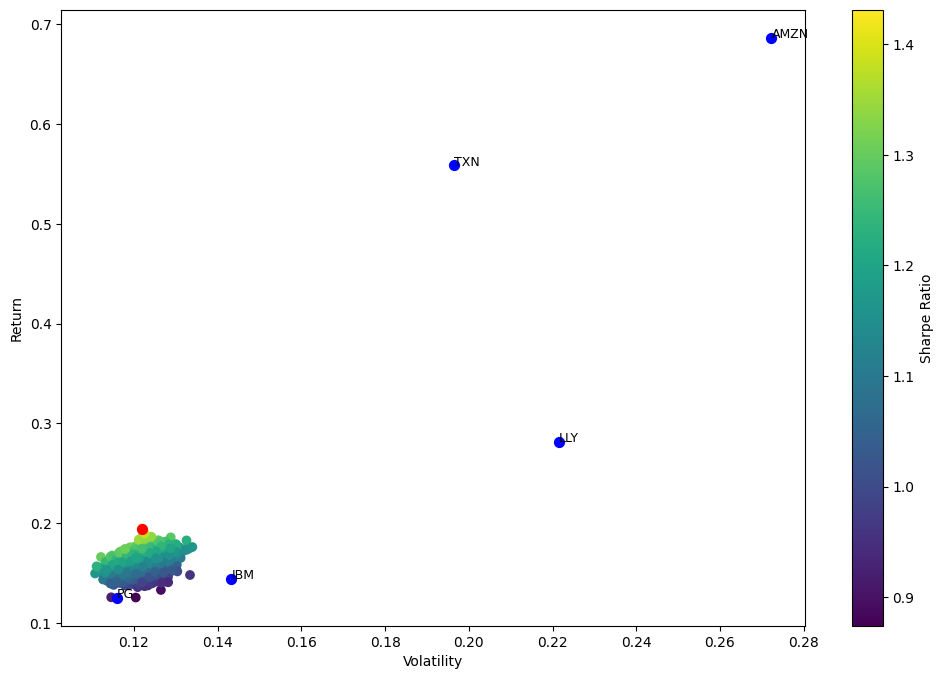

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# number of simulations
num_portfolios = 1000
risk_free_rate = 0.02  # assuming a risk-free rate of 1%
valid_tickers = valid_tickers
expected_returns = mu
covariance_matrix = S
optimized_weights = adjusted_weights
# pre-allocating space for each simulation's return and standard deviation
port_returns = np.zeros(num_portfolios)
port_volatility = np.zeros(num_portfolios)
sharpe_ratio = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    port_returns[i] = np.sum(expected_returns * weights)
    port_volatility[i] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio[i] = (port_returns[i] - risk_free_rate) / port_volatility[i]

plt.figure(figsize=(12, 8))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')

index_high_sharpe = np.argmax(sharpe_ratio)
plt.scatter(port_volatility[index_high_sharpe], port_returns[index_high_sharpe], c='red', s=50)



for index in tickers_to_buy_idx:
    ticker_name = valid_tickers[index]
    x = np.sqrt(S[ticker_name][ticker_name])
    y = exp_profits[index]
    plt.scatter(x, y, c='blue', s=50)
    plt.text(x, y, ticker_name, fontsize=9)



plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [279]:
print(portfolio_return(adjusted_weights, mu))
print(portfolio_volatility(adjusted_weights, S))

9.59622916186161
0.05066177710759178


In [283]:
mu

array([[ 0.6000572 ],
       [ 0.00328448],
       [ 0.24460852],
       [ 0.04439486],
       [ 0.15531322],
       [ 0.18533133],
       [ 0.04915312],
       [ 0.12223531],
       [ 0.21267194],
       [ 0.06521123],
       [-0.01302115],
       [ 0.08681719],
       [ 0.26876473],
       [ 0.27925998],
       [-0.06266544],
       [ 0.40393339],
       [ 0.07791322],
       [ 0.06647406],
       [ 0.39877872],
       [ 0.32789263],
       [ 0.1488702 ],
       [ 0.20966391],
       [-0.04255854],
       [-0.05606025],
       [-0.03997648],
       [ 0.10393165],
       [ 0.11601928],
       [-0.0164272 ],
       [ 0.05609233],
       [ 0.08287344],
       [-0.00815096],
       [ 0.12911717],
       [ 0.11104052],
       [ 0.01359091],
       [-0.00622627],
       [ 0.06269222],
       [ 0.00096797],
       [-0.01542905],
       [ 0.11238722],
       [ 0.13931198],
       [ 0.16965317],
       [ 0.15981081],
       [-0.02901215],
       [ 0.00319639],
       [ 0.10467948],
       [ 0